---------------

# **<font style="color:Black">Create OCR by PyTorch</font>**
-------------------
-----------------

In [1]:
#!pip install tensorboard
!tensorboard --version

2025-03-10 12:21:02.449542: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-10 12:21:02.696509: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-10 12:21:02.769060: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2.17.1


In [2]:
import os
import sys
import shutil
import random
from PIL import Image, ImageDraw, ImageFont, ImageEnhance, ImageFilter
import numpy as np
import cv2

import matplotlib.pyplot as plt
from collections import Counter

import random

import torch
import torch.nn as nn
import torch.nn.functional as F  # Add this import
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

## **<font style="color:blue">Hyperparameters</font>**
-------------------

In [3]:
seed = 3
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

In [4]:
OUTPUT_DIR = os.path.join('/kaggle','working','synthetic_data','images')
TENSORBOARD_DIR = os.path.join('/kaggle','working','runs')
MODEL_DIR = os.path.join('/kaggle','working','model_dir')
LABELS_FILE = os.path.join('/kaggle','working','synthetic_data','labels.txt')
NUM_SAMPLES = 5120  # Number of images generated
IMG_WIDTH = 128
IMG_HEIGHT = 32
BATCH_SIZE = 32
EPOCHS = 20
LEARNING_RATE = 5e-6 
WEIGHT_DECAY = 1e-4  
WARMUP_STEPS = 1000  
ENTROPY_WEIGHT = 2.0
TEMPERATURE = 0.3
DROPOUT = 0.7
BEAM_WIDTH = 10
LABEL_SMOOTHING = 0.2
BLANK_PENALTY_WEIGHT = 2.0
MAX_SEQ_LENGTH = None
CHARSET = "abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789-*"  # Group characters
MAX_TEXT_LENGTH = 10  # Maximum length of text in an image
FONT_DIR = os.path.join('/kaggle','input','google-fonts','GoogleFontScripts') # Folder with TrueType fonts (.ttf)
BACKGROUND_DIR = os.path.join('/kaggle','working','backgrounds')  # New folder for background (optional)
NUMBER_BACKGROUND_IMAGE = 1000

## **<font style="color:blue">Utils support functions</font>**
-------------------

### **<font style="color:green">Create output folders</font>**

In [5]:
os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(BACKGROUND_DIR, exist_ok=True)
os.makedirs(TENSORBOARD_DIR, exist_ok=True)

# Creates a new file
with open(LABELS_FILE, 'w') as fp:
    pass

### **<font style="color:green">Load the font list (add the paths to the .ttf files to the "fonts" folder)</font>**

In [6]:
font_files = [
    os.path.join(FONT_DIR, f) for f in os.listdir(FONT_DIR) 
    if f.endswith('.ttf') and os.path.isfile(os.path.join(FONT_DIR, f))
]
if not font_files:
    raise FileNotFoundError("No fonts found in 'fonts' folder. Add .ttf files!")

### **<font style="color:green">Generating a simple gradient background</font>**

In [7]:
def generate_gradient_background(filename, size=(128, 32)):
    img = Image.new('L', size, color=230)  # Lighter gray as a base
    draw = ImageDraw.Draw(img)
    for y in range(size[1]):
        # Soft gradient with low contrast
        color = int(230 - 20 * (y / size[1]))  # From light gray to slightly darker
        draw.line([(0, y), (size[0], y)], fill=color)
    # Background blur
    img = img.filter(ImageFilter.GaussianBlur(radius=2))
    img.save(os.path.join(BACKGROUND_DIR, filename))

### **<font style="color:green">Generate a background with noise (paper texture)</font>**

In [8]:
def generate_paper_texture(filename, size=(128, 32)):
    img = Image.new('L', size, color=220)  # Lighter gray
    noise = np.random.normal(0, 5, size).astype(np.uint8)  # Less noise
    noise_img = Image.fromarray(noise)
    img.paste(noise_img, (0, 0), noise_img)
    # Blur for a softer effect
    img = img.filter(ImageFilter.GaussianBlur(radius=1.5))
    img.save(os.path.join(BACKGROUND_DIR, filename))

### **<font style="color:green">Creating multiple backgrounds</font>**

In [9]:
for i in range(NUMBER_BACKGROUND_IMAGE):
    generate_gradient_background(f"gradient_{i}.png")
    generate_paper_texture(f"paper_{i}.png")

### **<font style="color:green">Load backgrounds (optional, add images to the "backgrounds" folder)</font>**

In [10]:
background_files = (
    [os.path.join(BACKGROUND_DIR, f) for f in os.listdir(BACKGROUND_DIR) 
     if f.endswith(('.png', '.jpg', '.jpeg'))] if os.path.exists(BACKGROUND_DIR) else []
)

### **<font style="color:green">Random text generation function</font>**

In [11]:
def generate_random_text(max_length):
    length = random.randint(1, max_length)
    return ''.join(random.choice(CHARSET) for _ in range(length))

### **<font style="color:green">Functions for adding noise and distortions</font>**

In [12]:
def add_noise_and_distortion(img):
    img_array = np.array(img)
    # Mild Gaussian noise with lower intensity
    if random.random() > 0.5:  # 50% šance
        noise = np.random.normal(0, random.randint(5, 15), img_array.shape).astype(np.uint8)
        img_array = cv2.add(img_array, noise)
    # Subtle perspective distortion
    rows, cols = img_array.shape
    src_points = np.float32([[0, 0], [cols-1, 0], [0, rows-1], [cols-1, rows-1]])
    dst_points = np.float32([
        [random.uniform(0, 3), random.uniform(0, 3)],
        [cols-1-random.uniform(0, 3), random.uniform(0, 3)],
        [random.uniform(0, 3), rows-1-random.uniform(0, 3)],
        [cols-1-random.uniform(0, 3), rows-1-random.uniform(0, 3)]
    ])
    matrix = cv2.getPerspectiveTransform(src_points, dst_points)
    img_array = cv2.warpPerspective(img_array, matrix, (cols, rows))
    return Image.fromarray(img_array)

### **<font style="color:green">Improved image generation feature</font>**

In [13]:
def generate_synthetic_image(text, font_path, img_size=(IMG_WIDTH, IMG_HEIGHT)):
    # Background
    if background_files:
        bg_path = random.choice(background_files)
        img = Image.open(bg_path).convert('L').resize(img_size)
    else:
        img = Image.new('L', img_size, color=230)
        draw = ImageDraw.Draw(img)
        for y in range(img_size[1]):
            color = int(230 - 20 * (y / img_size[1]))
            draw.line([(0, y), (img_size[0], y)], fill=color)
        img = img.filter(ImageFilter.GaussianBlur(radius=2))

    draw = ImageDraw.Draw(img)

    # Iterative font and text editing
    font_size = random.randint(20, min(IMG_HEIGHT-2, 28))
    max_attempts = 5  # Limiting the number of attempts
    for attempt in range(max_attempts):
        font = ImageFont.truetype(font_path, font_size)
        text_bbox = draw.textbbox((0, 0), text, font=font)
        text_width, text_height = text_bbox[2] - text_bbox[0], text_bbox[3] - text_bbox[1]

        if text_width <= IMG_WIDTH - 10:  # Text will fit
            break
        elif len(text) > 1:  # Shorten the text if it is too long.
            text = text[:len(text)//2]
        else:  # Reduce font size
            font_size = max(10, font_size - 5)  # Minimum size 10

    # If that doesn't work, use a minimal font and single-letter text.
    if text_width > IMG_WIDTH - 10:
        text = text[0]  # Use the first letter
        font_size = 10
        font = ImageFont.truetype(font_path, font_size)
        text_bbox = draw.textbbox((0, 0), text, font=font)
        text_width, text_height = text_bbox[2] - text_bbox[0], text_bbox[3] - text_bbox[1]

    # Text position
    x = random.randint(5, max(5, IMG_WIDTH - text_width - 5))
    y = random.randint(5, max(5, IMG_HEIGHT - text_height - 5))

    # Highlighting text
    text_color = random.randint(0, 50)
    outline_color = 200
    for offset_x in [-1, 0, 1]:
        for offset_y in [-1, 0, 1]:
            if offset_x != 0 or offset_y != 0:
                draw.text((x + offset_x, y + offset_y), text, font=font, fill=outline_color)
    draw.text((x, y), text, font=font, fill=text_color)

    # Noise and distortion
    img = add_noise_and_distortion(img)
    return img

### **<font style="color:green">Function for splitting labels</font>**

In [14]:
def split_labels(labels, label_lengths):
    """Split a flat tensor of labels into a list of label sequences based on lengths."""
    split_labels = []
    start = 0
    for length in label_lengths:
        split_labels.append(labels[start:start + length])
        start += length
    return split_labels

### **<font style="color:green">Function of Beam search decoding</font>**

In [15]:
def beam_search_decode(output, idx_to_char, target_lengths=None, beam_width=10, blank_penalty=-0.5, length_penalty=-0.5, global_step=None):
    probs = output.softmax(2).cpu().numpy()
    T, B, C = probs.shape
    predictions = []
    
    for b in range(B):
        sequence_probs = [(0.0, [], 1.0)]
        max_length = target_lengths[b].item() * 2 if target_lengths is not None else T
        for t in range(T):
            new_sequences = []
            for log_prob, seq, prob in sequence_probs:
                if len(seq) >= max_length:
                    new_sequences.append((log_prob, seq, prob))
                    continue
                top_k_probs, top_k_idx = torch.topk(torch.tensor(probs[t, b]), beam_width)
                for k_prob, k_idx in zip(top_k_probs, top_k_idx):
                    new_seq = seq + [k_idx.item()]
                    new_prob = prob * k_prob.item()
                    new_log_prob = log_prob + np.log(k_prob.item())
                    if k_idx.item() == 0:
                        new_log_prob += blank_penalty
                    new_log_prob += length_penalty * len(new_seq)
                    new_sequences.append((new_log_prob, new_seq, new_prob))
            sequence_probs = sorted(new_sequences, key=lambda x: x[0], reverse=True)[:beam_width]
        
        best_seq = sequence_probs[0][1]
        decoded = []
        prev = -1
        for idx in best_seq:
            if idx != 0 and idx != prev:
                decoded.append(idx_to_char.get(idx, ''))
            prev = idx
        predictions.append(''.join(decoded) if decoded else '<empty>')
    
        # Logging token distribution into TensorBoard
        token_counts = Counter(best_seq)
        for token, count in token_counts.items():
            writer.add_scalar(f'Token_Distribution/token_{token}', count, global_step)
        print(f"Token distribution (Batch {b}): {dict(token_counts)}")
    
    return predictions

### **<font style="color:green">Custom collate function</font>**

In [16]:
def custom_collate_fn(batch):
    images, labels, label_lengths = zip(*batch)
    # Stack images (all same size)
    images = torch.stack(images, dim=0)
    # Concatenate labels into a flat tensor
    labels = torch.cat(labels, dim=0)
    # Convert label_lengths to tensor
    label_lengths = torch.tensor(label_lengths, dtype=torch.long)
    return images, labels, label_lengths

### **<font style="color:green">Generování datasetu</font>**

In [17]:
def create_synthetic_dataset(num_samples):
    labels = []
    for i in range(num_samples):
        text = generate_random_text(MAX_TEXT_LENGTH)
        if not text:
            continue
        font_path = random.choice(font_files)
        img = generate_synthetic_image(text, font_path)
        img_name = f"img_{i:05d}.png"
        img_path = os.path.join(OUTPUT_DIR, img_name)
        img.save(img_path)
        labels.append(f"{img_name}\t{text}")  # Use tab (\t) instead of space
        if i % 100 == 0:
            print(f"Generated {i}/{num_samples} images")

    if labels:
        with open(LABELS_FILE, 'w') as f:
            f.write("\n".join(labels))
        print(f"Dataset generated! Images saved in '{OUTPUT_DIR}', labels in '{LABELS_FILE}'")
    else:
        print("No labels generated!")

## **<font style="color:blue">Mapping characters to indices and back</font>**
-------------------

In [18]:
char_to_idx = {char: idx + 1 for idx, char in enumerate(CHARSET)}  # 0 is reserved for blank (CTC)
idx_to_char = {idx: char for char, idx in char_to_idx.items()}

## **<font style="color:blue">Custom dataset</font>**
-------------------

In [19]:
class OCRDataset(Dataset):
    def __init__(self, image_dir, labels_file):
        self.image_dir = image_dir
        self.labels_file = labels_file
        self.data = []
        with open(labels_file, 'r') as f:
            for line in f:
                if not line.strip():  # Skip empty lines
                    continue
                image_path, label = line.strip().split('\t')
                label_length = len(label)
                self.data.append((image_path, label, label_length))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_path, label, label_length = self.data[idx]
        image = Image.open(os.path.join(self.image_dir, image_path)).convert('L')
        image = transforms.ToTensor()(image)
        label_encoded = torch.tensor([char_to_idx[c] for c in label], dtype=torch.long)
        return image, label_encoded, label_length

## **<font style="color:blue">Custom CTC Loss with Blank Penalty</font>**
-------------------
> CTC Loss with Entropy Regularization

In [20]:
class CTCLossWithBlankPenalty(nn.Module):
    def __init__(self, blank=0, zero_infinity=True, blank_penalty_weight=2.0, entropy_weight=2.0, label_smoothing=0.2):
        super().__init__()
        self.ctc_loss = nn.CTCLoss(blank=blank, zero_infinity=zero_infinity)
        self.blank_penalty_weight = blank_penalty_weight
        self.entropy_weight = entropy_weight
        self.label_smoothing = label_smoothing

    def forward(self, log_probs, targets, input_lengths, target_lengths):
        ctc_loss = self.ctc_loss(log_probs, targets, input_lengths, target_lengths)
        blank_probs = log_probs[:, :, 0].exp().mean()
        blank_penalty = torch.clamp(-torch.log(1 - blank_probs + 1e-6) * self.blank_penalty_weight, max=1.0)  # Klipování
        entropy = -(log_probs.exp() * log_probs).sum(dim=-1).mean()
        total_loss = ctc_loss + blank_penalty + self.entropy_weight * entropy
        return total_loss

## **<font style="color:blue">Model definition (CNN + RNN + CTC)</font>**
-------------------

In [21]:
class OCRModel(nn.Module):
    def __init__(self, num_chars):
        super(OCRModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.rnn = nn.LSTM(128 * (IMG_HEIGHT // 4), 256, num_layers=2, bidirectional=True, dropout=DROPOUT)
        self.fc = nn.Linear(256 * 2, num_chars)
        self.dropout = nn.Dropout(DROPOUT)

    def forward(self, x, max_length=None):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        batch, channels, height, width = x.size()
        x = x.view(batch, channels * height, width).permute(2, 0, 1)
        if max_length is not None:
            x = x[:max_length]
        x, _ = self.rnn(x)
        x = self.dropout(x)
        x = self.fc(x)
        return x

## **<font style="color:blue">Training</font>**
-------------------

In [22]:
def train_model(model, train_loader, criterion, optimizer, device, epoch, warmup_steps=WARMUP_STEPS):
    model.train()
    total_loss = 0
    global_step = epoch * len(train_loader)
    
    for batch_idx, (imgs, labels, label_lengths) in enumerate(train_loader):
        imgs, labels = imgs.to(device), labels.to(device)
        label_lengths = label_lengths.to(device)

        if global_step < warmup_steps:
            lr_scale = min(1.0, float(global_step + 1) / warmup_steps)
            for param_group in optimizer.param_groups:
                param_group['lr'] = LEARNING_RATE * lr_scale

        optimizer.zero_grad()
        # Dynamic setting of MAX_SEQ_LENGTH according to the maximum label length in the batch
        max_label_length = label_lengths.max().item() * 2
        outputs = model(imgs, max_length=max_label_length)
        outputs = outputs / TEMPERATURE
        outputs = outputs.log_softmax(2)

        batch_size = imgs.size(0)
        seq_length = outputs.size(0)
        input_lengths = torch.full((batch_size,), seq_length, dtype=torch.long).to(device)

        loss = criterion(outputs, labels, input_lengths, label_lengths)
        if torch.isnan(loss) or torch.isinf(loss):
            print(f"Warning: NaN or Inf loss at batch {batch_idx}. Skipping...")
            continue

        loss.backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.2)
        optimizer.step()
        total_loss += loss.item()
        global_step += 1

        if batch_idx % 10 == 0:
            with torch.no_grad():
                pred_texts = beam_search_decode(outputs, idx_to_char, label_lengths, global_step=global_step)
                raw_outputs = outputs.argmax(2).cpu().numpy()[:3]
                blank_probs = outputs[:, :, 0].exp().mean().item()
                label_sequences = split_labels(labels, label_lengths)
                ground_truth = [''.join([idx_to_char.get(idx.item(), '') for idx in label_seq])
                                for label_seq in label_sequences[:3]]
                # Average prediction length
                pred_lengths = [len(p) for p in pred_texts]
                avg_pred_length = sum(pred_lengths) / len(pred_lengths) if pred_lengths else 0
                
                # Logging into TensorBoard
                writer.add_scalar('Loss/train_batch', loss.item(), global_step)
                writer.add_scalar('Blank_Probability/train_batch', blank_probs, global_step)
                writer.add_scalar('Gradient_Norm/train_batch', grad_norm.item(), global_step)
                writer.add_scalar('Prediction_Length/avg_length', avg_pred_length, global_step)
                
                print(f"Batch {batch_idx}, Gradient norm: {grad_norm.item():.4f}")
                print(f"Epoch {epoch+1}, Batch {batch_idx}/{len(train_loader)}, Loss: {loss.item():.4f}")
                print(f"Avg Blank Probability: {blank_probs:.4f}")
                print(f"Sample predictions: {pred_texts[:3]}")
                print(f"Ground Truth (first 3): {ground_truth}")
                print(f"Raw outputs (first 3): {raw_outputs}")
                print(f"Avg Pred Length: {avg_pred_length:.2f}, Input length: {seq_length}, Label lengths: {label_lengths[:3].tolist()}")

    avg_loss = total_loss / len(train_loader)
    writer.add_scalar('Loss/train_epoch', avg_loss, epoch)
    return avg_loss

## **<font style="color:blue">Inference (prediction)</font>**
-------------------

In [23]:
def decode_prediction(output, idx_to_char):
    probs = output.softmax(2)
    max_probs, preds = probs.max(dim=2)
    preds = preds.cpu().numpy()
    max_probs = max_probs.cpu().numpy()
    texts = []
    for i, (pred, prob) in enumerate(zip(preds.T, max_probs.T)):
        print(f"Raw prediction {i} (pre-filter): {pred}, Max probs: {prob}")
        # Dynamic threshold: 75th percentile of max probs in this sequence
        threshold = np.percentile(prob, 75)
        print(f"Dynamic threshold for prediction {i}: {threshold:.4f}")
        pred_text = []
        prev = -1
        for idx, p in zip(pred, prob):
            if idx != 0 and idx != prev and p > threshold:
                pred_text.append(idx_to_char.get(idx, ''))
            prev = idx
        decoded = ''.join(pred_text)
        texts.append(decoded if decoded else '<empty>')
    return texts

## **<font style="color:blue">Main launch</font>**
-------------------

Generated 0/5120 images
Generated 100/5120 images
Generated 200/5120 images
Generated 300/5120 images
Generated 400/5120 images
Generated 500/5120 images
Generated 600/5120 images
Generated 700/5120 images
Generated 800/5120 images
Generated 900/5120 images
Generated 1000/5120 images
Generated 1100/5120 images
Generated 1200/5120 images
Generated 1300/5120 images
Generated 1400/5120 images
Generated 1500/5120 images
Generated 1600/5120 images
Generated 1700/5120 images
Generated 1800/5120 images
Generated 1900/5120 images
Generated 2000/5120 images
Generated 2100/5120 images
Generated 2200/5120 images
Generated 2300/5120 images
Generated 2400/5120 images
Generated 2500/5120 images
Generated 2600/5120 images
Generated 2700/5120 images
Generated 2800/5120 images
Generated 2900/5120 images
Generated 3000/5120 images
Generated 3100/5120 images
Generated 3200/5120 images
Generated 3300/5120 images
Generated 3400/5120 images
Generated 3500/5120 images
Generated 3600/5120 images
Generated 370

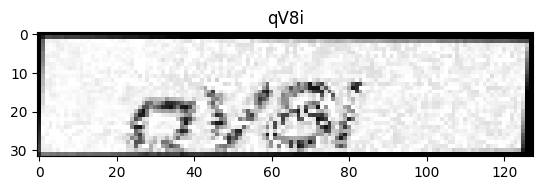

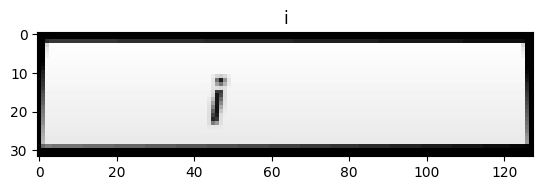

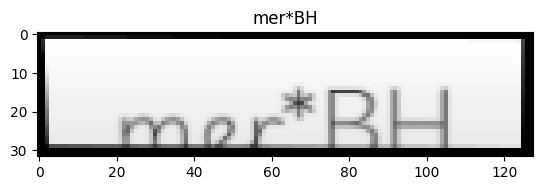

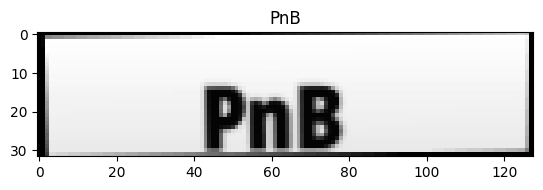

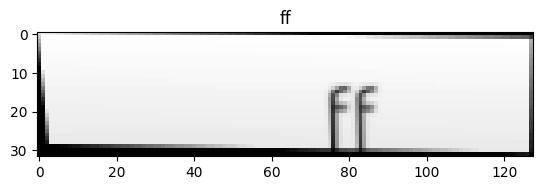

Epoch 1, Filtered data size: 2604, Sample labels: ['qV8i', 'i', 'PnB']
Train size: 2083, Val size: 521
Token distribution (Batch 0): {12: 1, 22: 1, 55: 1, 1: 1}
Token distribution (Batch 1): {5: 1, 12: 1, 10: 2, 56: 1, 6: 1, 1: 2}
Token distribution (Batch 2): {11: 1, 22: 1, 63: 1, 10: 1, 1: 1, 33: 1}
Token distribution (Batch 3): {11: 1, 5: 1, 34: 1, 14: 1, 1: 3, 47: 1, 19: 1, 27: 1}
Token distribution (Batch 4): {19: 2, 27: 1, 11: 1, 35: 1, 33: 1, 1: 1, 8: 1}
Token distribution (Batch 5): {12: 1, 32: 1, 56: 1, 1: 3, 22: 1, 11: 1}
Token distribution (Batch 6): {6: 1, 1: 5, 47: 1, 55: 1, 10: 1, 32: 1}
Token distribution (Batch 7): {47: 1, 10: 1}
Token distribution (Batch 8): {1: 3, 56: 1, 48: 1, 6: 1, 40: 1, 55: 1, 43: 1, 4: 1}
Token distribution (Batch 9): {27: 1, 1: 2, 10: 1, 34: 1, 4: 1, 56: 1, 47: 1}
Token distribution (Batch 10): {1: 1, 24: 1}
Token distribution (Batch 11): {1: 5, 56: 1, 42: 1, 32: 1, 47: 1, 22: 1}
Token distribution (Batch 12): {1: 1, 8: 1, 24: 1, 10: 1}
Token di

In [24]:
if __name__ == "__main__":
    # Inicializace TensorBoard writeru
    log_dir = "runs/ocr_experiment"
    if not os.path.exists(log_dir):
        os.makedirs(log_dir)
    writer = SummaryWriter(log_dir)

    if not font_files:
        print("Download some TrueType fonts (.ttf) and place them in the 'fonts' folder!")
    else:
        create_synthetic_dataset(NUM_SAMPLES)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    full_dataset = OCRDataset(image_dir=OUTPUT_DIR, labels_file=LABELS_FILE)

    for i in range(5):
        img, label, length = full_dataset[i]
        plt.imshow(img.squeeze(), cmap='gray')
        plt.title(''.join([idx_to_char.get(idx.item(), '') for idx in label[:length]]))
        plt.show()
    
    if len(full_dataset) == 0:
        print("Dataset is empty! Check labels.txt or image directory.")
    else:
        # Curriculum phases with pre-filtering
        model = OCRModel(num_chars=len(CHARSET)).to(device)
        criterion = CTCLossWithBlankPenalty(
            blank=0, zero_infinity=True, blank_penalty_weight=BLANK_PENALTY_WEIGHT,
            entropy_weight=ENTROPY_WEIGHT, label_smoothing=LABEL_SMOOTHING
        )
        
        optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=1e-6)

        best_loss = float('inf')
        
        for epoch in range(EPOCHS):
            # Filter full dataset based on curriculum phase
            if epoch < 10:
                filtered_data = [(img, lbl, lbl_len) for img, lbl, lbl_len in full_dataset.data if lbl_len <= 5]
                sample_labels = [lbl for _, lbl, _ in filtered_data[:3]]  # lbl je řetězec
                print(f"Epoch {epoch+1}, Filtered data size: {len(filtered_data)}, Sample labels: {sample_labels}")
            elif epoch < 15:
                filtered_data = [(img, lbl, lbl_len) for img, lbl, lbl_len in full_dataset.data if lbl_len <= 7]
                sample_labels = [lbl for _, lbl, _ in filtered_data[:3]]
                print(f"Epoch {epoch+1}, Filtered data size: {len(filtered_data)}, Sample labels: {sample_labels}")
            else:
                filtered_data = full_dataset.data
                sample_labels = [lbl for _, lbl, _ in filtered_data[:3]]
                print(f"Epoch {epoch+1}, Filtered data size: {len(filtered_data)}, Sample labels: {sample_labels}")

            # Create a new dataset with filtered data
            curr_dataset = OCRDataset(image_dir=OUTPUT_DIR, labels_file=LABELS_FILE)
            curr_dataset.data = filtered_data  # Overwrite with filtered data

            # Split into train and validation
            train_size = int(0.8 * len(curr_dataset))
            val_size = len(curr_dataset) - train_size
            train_dataset, val_dataset = torch.utils.data.random_split(curr_dataset, [train_size, val_size])
            print(f"Train size: {len(train_dataset)}, Val size: {len(val_dataset)}")
            
            # Create data loaders
            train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=custom_collate_fn)
            val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=custom_collate_fn)
            
            # Training with TensorBoard logging
            model.train()
            total_loss = 0
            global_step = epoch * len(train_loader)
            for batch_idx, (imgs, labels, label_lengths) in enumerate(train_loader):
                imgs, labels = imgs.to(device), labels.to(device)
                label_lengths = label_lengths.to(device)

                if global_step < WARMUP_STEPS:
                    lr_scale = min(1.0, float(global_step + 1) / WARMUP_STEPS)
                    for param_group in optimizer.param_groups:
                        param_group['lr'] = LEARNING_RATE * lr_scale

                optimizer.zero_grad()
                outputs = model(imgs)
                outputs = outputs / TEMPERATURE
                outputs = outputs.log_softmax(2)

                batch_size = imgs.size(0)
                seq_length = outputs.size(0)
                input_lengths = torch.full((batch_size,), seq_length, dtype=torch.long).to(device)

                loss = criterion(outputs, labels, input_lengths, label_lengths)
                if torch.isnan(loss) or torch.isinf(loss):
                    print(f"Warning: NaN or Inf loss at batch {batch_idx}. Skipping...")
                    continue

                loss.backward()
                grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.1)
                optimizer.step()
                total_loss += loss.item()
                global_step += 1

                if batch_idx % 10 == 0:
                    with torch.no_grad():
                        pred_texts = beam_search_decode(outputs, idx_to_char, label_lengths)
                        raw_outputs = outputs.argmax(2).cpu().numpy()[:3]
                        blank_probs = outputs[:, :, 0].exp().mean().item()
                        label_sequences = split_labels(labels, label_lengths)
                        ground_truth = [''.join([idx_to_char.get(idx.item(), '') for idx in label_seq])
                                        for label_seq in label_sequences[:3]]
                        
                        # Logování do TensorBoard
                        writer.add_scalar('Loss/train_batch', loss.item(), global_step)
                        writer.add_scalar('Blank_Probability/train_batch', blank_probs, global_step)
                        writer.add_scalar('Gradient_Norm/train_batch', grad_norm.item(), global_step)
                        
                        print(f"Batch {batch_idx}, Gradient norm: {grad_norm.item():.4f}")
                        print(f"Epoch {epoch+1}, Batch {batch_idx}/{len(train_loader)}, Loss: {loss.item():.4f}")
                        print(f"Avg Blank Probability: {blank_probs:.4f}")
                        print(f"Sample predictions: {pred_texts[:3]}")
                        print(f"Ground Truth (first 3): {ground_truth}")
                        print(f"Raw outputs (first 3): {raw_outputs}")
                        print(f"Input length: {seq_length}, Label lengths: {label_lengths[:3].tolist()}")

            avg_loss = total_loss / len(train_loader)
            writer.add_scalar('Loss/train_epoch', avg_loss, epoch)
            print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {avg_loss:.4f}")

            # Validation with TensorBoard logging
            model.eval()
            val_loss = 0
            val_blank_probs = 0
            with torch.no_grad():
                for batch_idx, (imgs, labels, label_lengths) in enumerate(val_loader):
                    imgs, labels = imgs.to(device), labels.to(device)
                    label_lengths = label_lengths.to(device)
                    outputs = model(imgs)
                    outputs = outputs.log_softmax(2)
                    seq_length = outputs.size(0)
                    input_lengths = torch.full((imgs.size(0),), seq_length, dtype=torch.long).to(device)
                    val_loss += criterion(outputs, labels, input_lengths, label_lengths).item()
                    val_blank_probs += outputs[:, :, 0].exp().mean().item()
                
                val_loss /= len(val_loader)
                val_blank_probs /= len(val_loader)
                pred_texts = beam_search_decode(outputs, idx_to_char, label_lengths)
                label_sequences = split_labels(labels, label_lengths)
                ground_truth = [''.join([idx_to_char.get(idx.item(), '') for idx in label_seq])
                                for label_seq in label_sequences[:5]]
                
                # Validation logging to TensorBoard
                writer.add_scalar('Loss/val_epoch', val_loss, epoch)
                writer.add_scalar('Blank_Probability/val_epoch', val_blank_probs, epoch)
                print(f"Validation Loss: {val_loss:.4f}")
                print("Validation Predictions:", pred_texts[:5])
                print("Ground Truth:", ground_truth)

            scheduler.step()
            print(f"Current Learning Rate: {optimizer.param_groups[0]['lr']}")

            if val_loss < best_loss:
                best_loss = val_loss
                torch.save(model.state_dict(), os.path.join(MODEL_DIR, 'best_ocr_model.pth'))

        torch.save(model.state_dict(), os.path.join(MODEL_DIR, 'final_ocr_model.pth'))
    
    # Closing the TensorBoard writer
    writer.close()

In [25]:
def zip_folder_with_shutil(source_folder, output_path):
    '''Function for zip dir data'''
    shutil.make_archive(output_path, 'zip', source_folder)

In [26]:
zip_folder_with_shutil('/kaggle/working/backgrounds', '/kaggle/working/backgrounds')
zip_folder_with_shutil('/kaggle/working/synthetic_data', '/kaggle/working/synthetic_data')
zip_folder_with_shutil('/kaggle/working/model_dir', '/kaggle/working/model_dir')

In [27]:
zip_folder_with_shutil('/kaggle/working/runs', '/kaggle/working/runs')

In [28]:
#!tensorboard --logdir=/kaggle/working/runs --port 6006